# Fraktale - Projekt 2
## Andrzej Pióro | Damian Skowroński

***Symulacja "pożaru lasu" z wykorzystaniem metody Monte Carlo i analiza czasu trwania pożaru w kontekście struktury sieci.***

In [1]:
import os
import numpy as np
import pandas as pd
from random import choice
from tqdm.notebook import tqdm

import imageio.v2 as imageio
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import warnings
warnings.filterwarnings("ignore")


##########################
# Forest Fire Simulation #
##########################


def generate_forest_graph(size, structure, tree_prob):
    G = nx.Graph()

    if structure == "rectangular":
        for i in range(size):
            for j in range(size):
                G.add_node((i, j))

        for i in range(size):
            for j in range(size):
                if (i + 1, j) in G.nodes and np.random.rand() < tree_prob:
                    G.add_edge((i, j), (i + 1, j))
                if (i, j + 1) in G.nodes and np.random.rand() < tree_prob:
                    G.add_edge((i, j), (i, j + 1))

    elif structure == "hexagonal":
        for i in range(size):
            for j in range(size):
                if np.random.rand() < tree_prob:
                    G.add_node((i, j))

                    # Connect horizontally and vertically
                    if (i - 1, j) in G.nodes:
                        G.add_edge((i, j), (i - 1, j))
                    if (i, j - 1) in G.nodes:
                        G.add_edge((i, j), (i, j - 1))

                    # Connect diagonally based on row parity
                    if i % 2 == 0:
                        if (i - 1, j - 1) in G.nodes:
                            G.add_edge((i, j), (i - 1, j - 1))
                        if (i + 1, j - 1) in G.nodes:
                            G.add_edge((i, j), (i + 1, j - 1))
                    else:
                        if (i - 1, j + 1) in G.nodes:
                            G.add_edge((i, j), (i - 1, j + 1))
                        if (i + 1, j + 1) in G.nodes:
                            G.add_edge((i, j), (i + 1, j + 1))

    else:
        raise ValueError("Invalid structure type. Use 'rectangular' or 'hexagonal'.")

    for i in range(size):
        for j in range(size):
            if np.random.rand() > tree_prob and (i, j) in G.nodes:
                G.remove_node((i, j))

    return G


def visualize_forest_graph(G, title=None):
    pos = {node: (node[1], -node[0]) for node in G.nodes}
    nx.draw(G, pos, node_color="green")
    plt.title(title)
    plt.show()


def visualize_burnt_forest(G, ignition_point, burnt_nodes, title=None, visualise=False):
    fig = plt.figure(figsize=(10, 10))

    pos = {
        node: (node[1], -node[0]) for node in G.nodes
    }  # Flip the y-axis for better visualization
    node_colors = [
        "black" if node == ignition_point else "red" if node in burnt_nodes else "green"
        for node in G.nodes
    ]
    nx.draw(G, pos, node_color=node_colors, node_size=30)
    if title:
        plt.title(title)

    plt.margins(0, 0)
    if visualise:
        plt.show()
    return plt


def spread_fire_graph(G, ignition_point, fire_prob, save_outcome=False):
    burned_nodes = set()
    burning_nodes = {ignition_point}
    steps = 0
    plots = []
    while burning_nodes:
        steps += 1
        new_burning_nodes = set()
        for node in burning_nodes:
            neighbors = list(G.neighbors(node))
            for neighbor in neighbors:
                if neighbor not in burned_nodes and np.random.rand() < fire_prob:
                    new_burning_nodes.add(neighbor)
                    burned_nodes.add(neighbor)

        burning_nodes = new_burning_nodes

        if save_outcome:
            plots.append(
                {
                    "G": G.copy(),
                    "burned_nodes": burned_nodes.copy(),
                    "burning_nodes": burning_nodes.copy(),
                }
            )
    return burned_nodes, steps, plots


def simulate_forest_fire_graph(
    size,
    structure,
    tree_prob,
    fire_prob,
    num_simulations,
    visualise=False,
    save_outcome=False,
):
    steps_to_extinguish = []
    percent_burnt_down = []
    burned_plots = []

    for _ in tqdm(range(num_simulations)):
        G = generate_forest_graph(size, structure, tree_prob)
        # Uncomment the line below to visualize each forest
        # if visualise:
        #     visualize_forest_graph(G,structure)

        ignition_point = choice(list(G.nodes()))
        if ignition_point in G.nodes:
            burned_nodes, steps, plots = spread_fire_graph(
                G, ignition_point, fire_prob, save_outcome=save_outcome
            )

            burned_plots.append(plots)
            steps_to_extinguish.append(steps)

            percent_burnt = len(burned_nodes) / len(G.nodes)
            percent_burnt_down.append(percent_burnt)

            # Uncomment the line below to visualize each burnt forest
            if visualise:
                visualize_burnt_forest(G, ignition_point, burned_nodes, visualise=True)

    avg_steps = np.mean(steps_to_extinguish)
    avg_percent_burnt = np.mean(percent_burnt_down)

    # Get the value closest to the mean
    if save_outcome:
        average_outcome = burned_plots[
            np.argmin(np.abs(percent_burnt_down - avg_percent_burnt))
        ]
    else:
        average_outcome = None

    return avg_steps, avg_percent_burnt, average_outcome


######################
# Saving the Outcome #
######################


def save_gif_from_images(directory_name):
    images = []
    filenames = os.listdir(directory_name)
    filenames.sort()
    for filename in filenames:
        file_path = os.path.join(directory_name, filename)
        images.append(imageio.imread(file_path))
    imageio.mimsave(directory_name + ".gif", images, duration=0.3)


def save_frames(average_outcome, directory_name):
    plt.ioff()
    for i, plot in enumerate(average_outcome):
        figure = visualize_burnt_forest(
            plot["G"], (0, 0), plot["burned_nodes"], visualise=False
        )
        plt.savefig(f"{directory_name}/{str(i).zfill(3)}.png", dpi=100)
        plt.close()

### Wykonanie pojedynczej symulacji i zobaczenie wyniku

  0%|          | 0/1 [00:00<?, ?it/s]

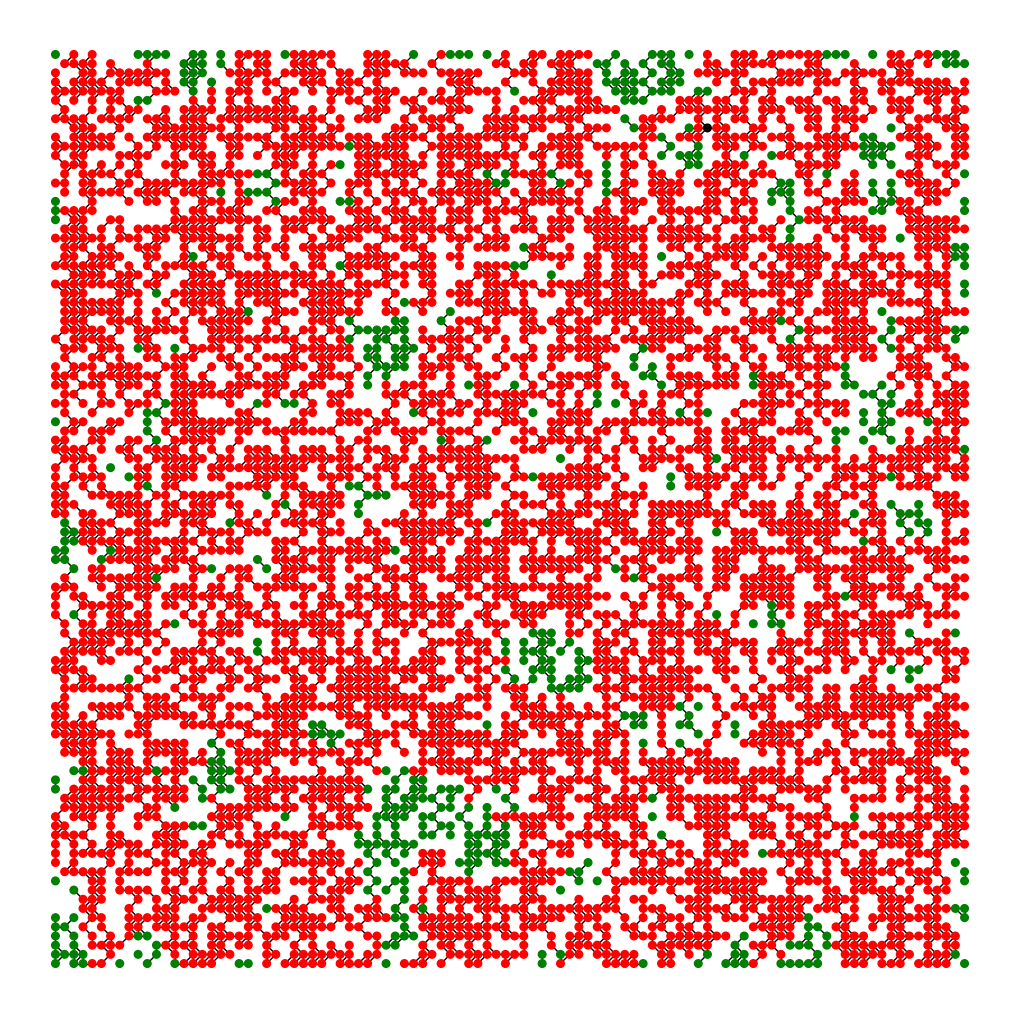

In [2]:
forest_size = 100
forest_structure = "hexagonal"
tree_probability = 0.8
fire_spread_probability = 0.75
num_simulations = 1


avg_steps, avg_percent_burnt, average_outcome = simulate_forest_fire_graph(
    forest_size,
    forest_structure,
    tree_probability,
    fire_spread_probability,
    num_simulations,
    visualise=True,
    save_outcome=False,
)

### Zapis kolejnych kroków przeciętnej symulacji do plików png, i stworzenie pliku gif.

In [66]:
forest_size = 100
forest_structure = "hexagonal"
tree_probability = 0.8
fire_spread_probability = 0.75
num_simulations = 10

plt.ioff()
avg_steps, avg_percent_burnt, average_outcome = simulate_forest_fire_graph(
    forest_size,
    forest_structure,
    tree_probability,
    fire_spread_probability,
    num_simulations,
    visualise=False,
    save_outcome=True,
)

save_frames(average_outcome, "hexagonal_tp08_fsp075")
save_gif_from_images("hexagonal_tp08_fsp075")

  0%|          | 0/10 [00:00<?, ?it/s]

### Symulacje Monte Carlo

In [ ]:
# Running the simulation for different tree probabilities

df = pd.DataFrame(
    columns=[
        "forest_size",
        "forest_structure",
        "tree_probability",
        "fire_spread_probability",
        "num_simulations",
        "avg_steps",
        "avg_percent_burnt",
    ]
)

# Parameters
forest_size = 100
forest_structure = "hexagonal"
tree_probabilities = [0.8, 0.9, 1]
fire_spread_probabilities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
num_simulations = 500


for tree_probability in tqdm(tree_probabilities):
    for fire_spread_probability in tqdm(fire_spread_probabilities):
        avg_steps, avg_percent_burnt, average_outcome = simulate_forest_fire_graph(
            forest_size,
            forest_structure,
            tree_probability,
            fire_spread_probability,
            num_simulations,
            visualise=False,
            save_outcome=False,
        )
        df = pd.concat(
            [
                df,
                pd.DataFrame(
                    {
                        "forest_size": forest_size,
                        "forest_structure": forest_structure,
                        "tree_probability": tree_probability,
                        "fire_spread_probability": fire_spread_probability,
                        "num_simulations": num_simulations,
                        "avg_steps": avg_steps,
                        "avg_percent_burnt": avg_percent_burnt,
                    },
                    index=[0],
                ),
            ]
        )

# saving the dataframe
df.to_csv("simulation_data.csv", index=False)

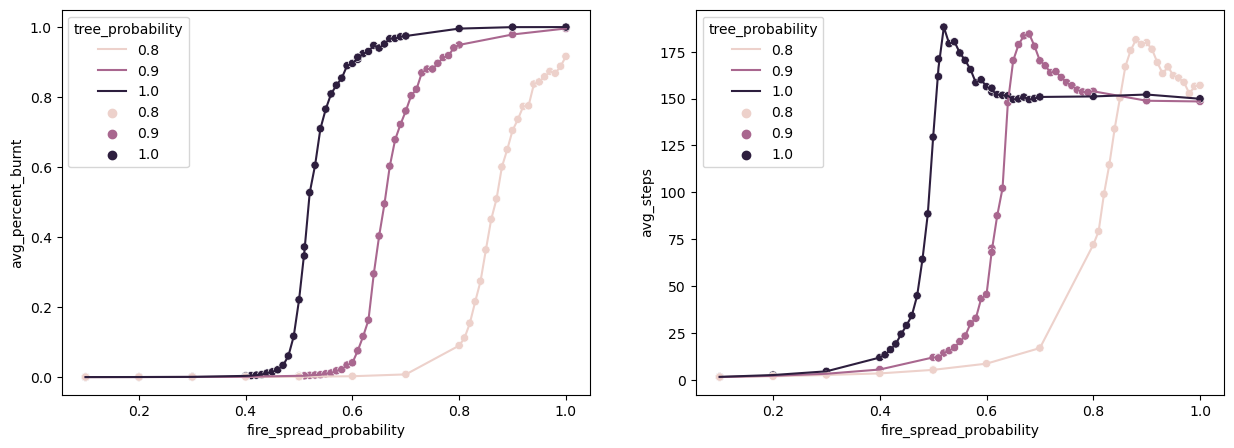

In [6]:
df = pd.read_csv("rectangular.csv")

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(
    x="fire_spread_probability",
    y="avg_percent_burnt",
    data=df,
    hue="tree_probability",
    ax=ax[0],
)

sns.lineplot(
    x="fire_spread_probability",
    y="avg_steps",
    data=df,
    hue="tree_probability",
    ax=ax[1],
)

# add points to the plot
sns.scatterplot(
    x="fire_spread_probability",
    y="avg_percent_burnt",
    data=df,
    hue="tree_probability",
    ax=ax[0],
)
sns.scatterplot(
    x="fire_spread_probability",
    y="avg_steps",
    data=df,
    hue="tree_probability",
    ax=ax[1],
)
fig.show()

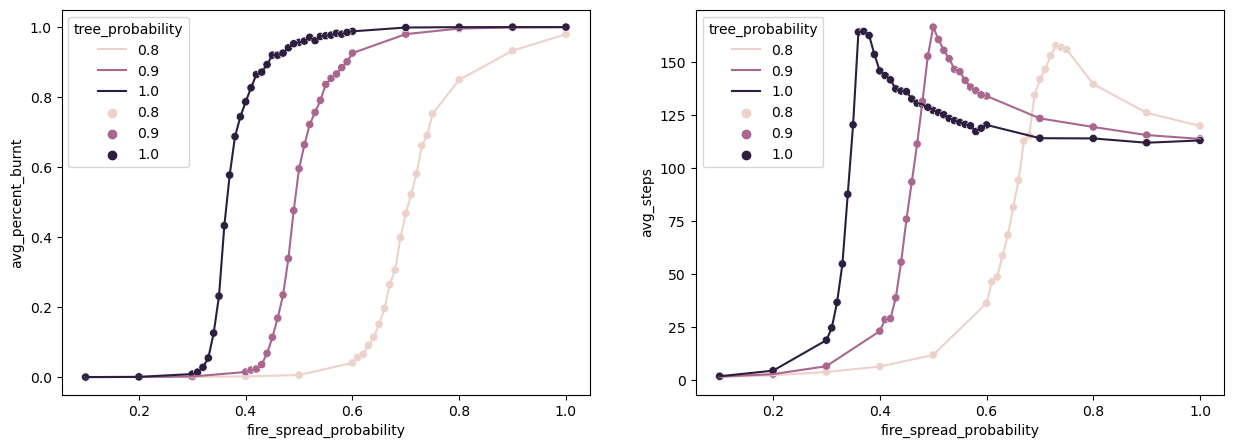

In [8]:
df = pd.read_csv("hexagonal.csv")


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(
    x="fire_spread_probability",
    y="avg_percent_burnt",
    data=df,
    hue="tree_probability",
    ax=ax[0],
)

sns.lineplot(
    x="fire_spread_probability",
    y="avg_steps",
    data=df,
    hue="tree_probability",
    ax=ax[1],
)

# add points to the plot
sns.scatterplot(
    x="fire_spread_probability",
    y="avg_percent_burnt",
    data=df,
    hue="tree_probability",
    ax=ax[0],
)
sns.scatterplot(
    x="fire_spread_probability",
    y="avg_steps",
    data=df,
    hue="tree_probability",
    ax=ax[1],
)

fig.show()